In [1]:
import numpy as np
import fiducial as fid
import matplotlib.pyplot as plt
import utils as u
import Eg_cov as egcov
import pyccl.nl_pt as pt

Check what happens when you use a nonlinear galaxy bias to the linear scale cuts.

Set up parameters etc

In [2]:
lens = 'DESI'
src = 'LSSTY10'

Pimax=900.
#rp_bin_edges = np.logspace(np.log10(rp0), np.log10(50.), 11)
endfilename='_Oct2025'
#rp_bin_c = u.rp_bins_mid(rp_bin_edges)
# Let's use the same cosmological parameters as Shadab's simulations:
h=0.69
OmB = 0.022/h**2

# Using now nonlinear bias parameters as fit in Kitanis & White 2022. 
# They fit LTP parameters so we convert these to their Eulerian equivalents.
b1_LPT = 1.333
b2_LPT = 0.514
bs_LPT = 0 # They fix this to 0.

# Convert to Eulerian using the conversions in Chen, Vlah & White 2020 (these use the same convention as Kitanis & White 2022)
b1 = 1.0 + b1_LPT
b2 = b2_LPT + 8./21.*(b1_LPT)
bs = bs_LPT - 2./7*(b1_LPT)

#b1 = 2.03
#b2 = 0.9*(b1-1.0)**2-0.5 # From Fast-PT example notebook which says 
#'(this is a numerical fit to simulation k2Pnl1_regdata, but a relationship of this form is motivated in the spherical collapse picture'
#bs = -4.0/7.0*(b1-1.0) # The 'coevolution value' see Pandey et al. DES Y3 papers

params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965, 'A_s':2.115 * 10**(-9),'b':b1, 'OmM': 0.292, 'b_2':b2, 'b_s': bs} 

#Nsamps=100000

print('b1=', b1)
print('b2=', b2)
print('bs=', bs)


b1= 2.333
b2= 1.021809523809524
bs= -0.38085714285714284


In [3]:
rp0 = 1.5

rp_bin_c_raw = np.loadtxt('../data_for_Danielle/test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
rp_bin_edges_raw = u.rp_bin_edges_log(rp_bin_c_raw)
#Cut below rp0 making sure rp0 is in the lowest bin. Go one bin lower because this 
ind = next(j[0] for j in enumerate(rp_bin_edges_raw) if j[1]>rp0)
rp_bin_c = rp_bin_c_raw[ind:][4:]
rp_bin_edges = rp_bin_edges_raw[ind:][4:]

print('rp bin c=', rp_bin_c)
print('rp bin edges=', rp_bin_edges)

rp bin c= [ 5.54793718  7.31360558  9.64120984 12.70958983 16.75450244 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]
rp bin edges= [  4.83205129   6.36988417   8.39714273  11.06958999  14.5925616   19.23674266  25.35896564  33.42962733  44.0688315   58.09403408  76.5828519  100.95586057]


Get data covariance matrices for E_G and the joint probes case.

In [4]:
#Dcov_jp = jp.get_joint_covariance(params, lens, src, rp_bin_edges, rp_bin_c, rp0, endfilename)
#np.savetxt('/home/danielle/Documents/CMU/Research/EG_comparison/txtfiles/Dcov_jp_'+endfilename+'.txt', Dcov_jp)
#Dcov_jp = np.loadtxt('../txtfiles/joint_covariance_rp0=1.5_Jul2025.dat')
#Dcov_jp_raw = np.loadtxt('../txtfiles/joint_covariance_rp0=1.5_Jul2025.dat')
#Dcov_jp_raw = np.loadtxt('../txtfiles/joint_covariance_rp0=1.5_Jul2025_LSSTY10.dat')
Dcov_jp_raw = np.loadtxt('../txtfiles/sims_cov_Msolunits_LSSTY10_addSNmat.dat')

Dcov_jp = np.delete(np.delete(Dcov_jp_raw, [0,1,2,3,15,16,17,18], axis=0), [0,1,2,3,15,16,17,18], axis=1)

print(Dcov_jp.shape)

(23, 23)


In [5]:
#Dcov_eg = egcov.get_egcov(params, rp_bin_edges, rp_bin_c, rp0, lens, src, Pimax, Nsamps, endfilename)
#np.savetxt('/home/danielle/Documents/CMU/Research/EG_comparison/txtfiles/Dcov_eg_'+endfilename+'.txt', Dcov_eg)
#Dcov_eg_raw = np.loadtxt('../txtfiles/eg_cov_Y1.dat')
#Dcov_eg_raw = np.loadtxt('../txtfiles/eg_cov_Y10.dat')
Dcov_eg_raw = np.loadtxt('../txtfiles/sim_eg_cov_Y10_addSN.dat')

Dcov_eg = Dcov_eg_raw[4:,4:]

print(Dcov_eg.shape)

(11, 11)


Get the linear and nonlinear datavector for E_G

In [6]:
# Get linear datavector
data_lin_EG = fid.E_G(params, rp_bin_edges, rp0, lens, src, Pimax, endfilename, nonlin=False)
# Get nonlinear datavector
data_nl_EG = fid.E_G(params, rp_bin_edges, rp0, lens, src, Pimax, endfilename, nonlin=True, nl_bias=True)

getting Upgm
maxchi= 6669.353003473356
end of upsgm binned
getting Upgg
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
end of upsgm binned
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.


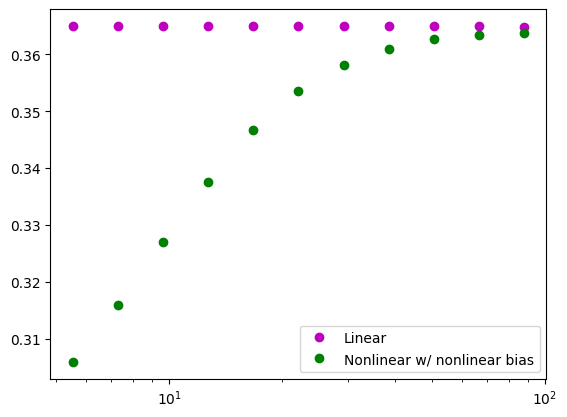

In [7]:
plt.figure()
plt.semilogx(rp_bin_c, data_lin_EG, 'mo', label='Linear')
plt.semilogx(rp_bin_c, data_nl_EG, 'go', label='Nonlinear w/ nonlinear bias')
plt.legend()
plt.show()

Get scale cuts for Eg

In [8]:
cut_inds_Eg = u.linear_scale_cuts_hartlap(data_nl_EG, data_lin_EG, Dcov_eg, rp_bin_c, covsamps=100)

chi2_temp= [137.6217465  139.97461226 165.76329477 171.24765453 169.89252222 176.04438457 176.66409747 179.29699463 179.28208473 174.61134979 165.53258971]
ind_min= 0
chi2_temp= [ 80.78851362 123.24337416 138.33640269 131.52352719 135.10912227 135.28188051 139.15847272 139.13175934 138.20749563 133.13533988]
ind_min= 0
chi2_temp= [37.3992432  81.12402062 78.35574474 77.25949175 81.03466188 80.88215946 81.69048759 80.69240846 78.25897049]
ind_min= 0
chi2_temp= [12.88441196 37.61519707 35.02735483 36.50486199 37.55907743 37.81443461 37.44478375 37.001081  ]
ind_min= 0
chi2_temp= [ 4.38385731 12.30330132 12.26468637 12.73515612 12.9253165  13.01891262 12.92768485]
ind_min= 0
chi2_temp= [1.28456851 4.12984511 3.75055122 4.42121303 4.34884494 4.36410112]
ind_min= 0
chi2_temp= [0.1535705  0.64951695 1.29692564 1.24435289 1.2565432 ]
ind_min= 0
ex_inds= [0, 1, 2, 3, 4, 5, 6]


In [9]:
print("cut indices=", cut_inds_Eg)

cut indices= [0, 1, 2, 3, 4, 5, 6]


Now get the linear and nonlinear data vectors for the joint probes case

In [10]:
data_lin_jp = fid.jp_datavector(params, rp_bin_edges, rp0, lens,src, Pimax, endfilename, nonlin = False)
data_nl_jp = fid.jp_datavector(params, rp_bin_edges, rp0, lens,src, Pimax, endfilename, nonlin = True, nl_bias=True)

maxchi= 6669.353003473356
end of upsgm binned
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
end of upsgm binned


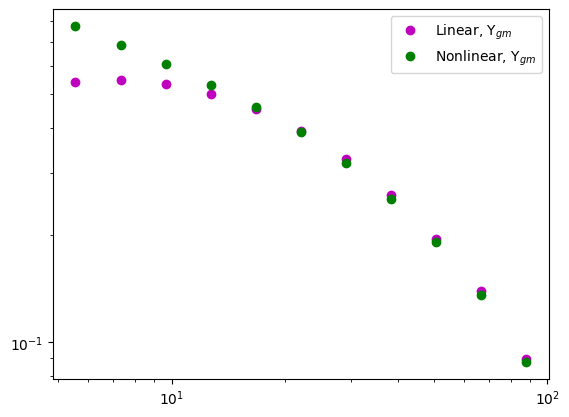

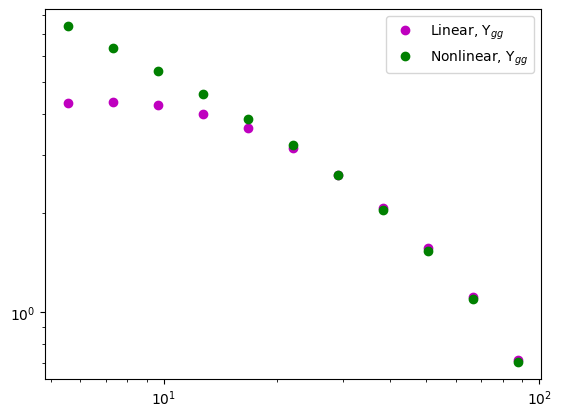

beta, lin= 0.342906677696308
beta, nl= 0.342906677696308


In [11]:
plt.figure()
plt.loglog(rp_bin_c, data_lin_jp[0:len(rp_bin_c)], 'mo', label='Linear, $\\Upsilon_{gm}$')
plt.loglog(rp_bin_c, data_nl_jp[0:len(rp_bin_c)], 'go', label='Nonlinear, $\\Upsilon_{gm}$')
plt.legend()
plt.show()

plt.figure()
plt.loglog(rp_bin_c, data_lin_jp[len(rp_bin_c):2*len(rp_bin_c)], 'mo', label='Linear, $\\Upsilon_{gg}$')
plt.loglog(rp_bin_c, data_nl_jp[len(rp_bin_c):2*len(rp_bin_c)], 'go', label='Nonlinear, $\\Upsilon_{gg}$')
plt.legend()
plt.show()

# Check that beta is the same in the linear or nonlinear case
print("beta, lin=", data_lin_jp[-1])
print("beta, nl=", data_nl_jp[-1])

In [12]:
cut_inds_jp = u.linear_scale_cuts_hartlap(data_nl_jp, data_lin_jp, Dcov_jp, rp_bin_c, covsamps=100)

chi2_temp= [6783.27274059 6856.97412329 6780.48145306 6843.7984448  6807.62719252 6859.08297752 6834.46418694 6858.61985141 6858.64437189 6859.05784034 6754.65868789 5037.6959071  6100.58141248 6579.08355625 6769.28038596 6801.74700037 6842.00155131
 6833.84551081 6855.71624842 6810.48360747 6838.49453331 6444.56875709 6822.54371951]
ind_min= 11
chi2_temp= [4586.7144507  5094.48265506 5066.15651938 5101.32676085 5058.41443726 5102.11570534 5091.24996875 5102.72200383 5071.4488844  5002.64975652 5098.74057717 3599.44299724 4822.17503532 5103.36580363 5088.40135794 5090.70651182 5098.42902654
 5098.7033726  4996.35823161 5080.40745447 4889.46091039 5023.17265605]
ind_min= 11
chi2_temp= [2426.67229925 3486.37186807 3602.35458512 3638.66212884 3613.31626569 3643.13696999 3645.81736526 3646.13988187 3628.2253042  3569.60047213 3633.16538439 3024.25761054 3608.43121833 3590.38915453 3627.14922195 3642.6321041  3637.26312214
 3547.57537667 3626.10126703 3551.40475708 3630.90034908]
ind_min= 0

In [13]:
print("cut indices=", cut_inds_jp)

cut indices= [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22]


For joint probes, we disect this to find the elements to cut for individual probes.

In [14]:
cut_indices_gm = [ind for ind in cut_inds_jp if ind<len(rp_bin_c)]
ind_keep_gm = [ind for ind in range(0,len(rp_bin_c)) if ind not in cut_indices_gm]
rp_keep_gm = rp_bin_c[ind_keep_gm]
Ups_keep_gm = data_nl_jp[ind_keep_gm]
print(zip(rp_keep_gm, Ups_keep_gm))

cut_indices_gg = [(ind-len(rp_bin_c)) for ind in cut_inds_jp if ind>=len(rp_bin_c)]
ind_keep_gg = [ind for ind in range(0,len(rp_bin_c)) if ind not in cut_indices_gg]
ind_keep_gg_dvec = [ind+len(rp_bin_c) for ind in range(0,len(rp_bin_c)) if ind not in cut_indices_gg]
rp_keep_gg = rp_bin_c[ind_keep_gg]
Ups_keep_gg = data_nl_jp[ind_keep_gg_dvec]
print(zip(rp_keep_gg, Ups_keep_gg))

ind_keep_Eg = [ind for ind in range(0,len(rp_bin_c)) if ind not in cut_inds_Eg]
rp_keep_Eg = rp_bin_c[ind_keep_Eg]
Eg_keep = data_nl_EG[ind_keep_Eg]

Plot the data points this tells us to keep for joint probes (not many)

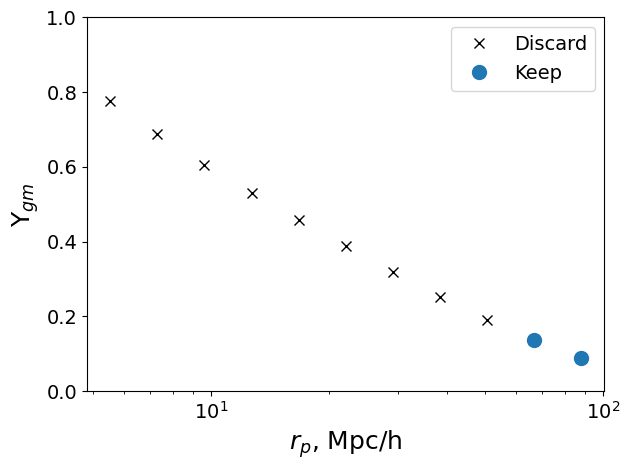

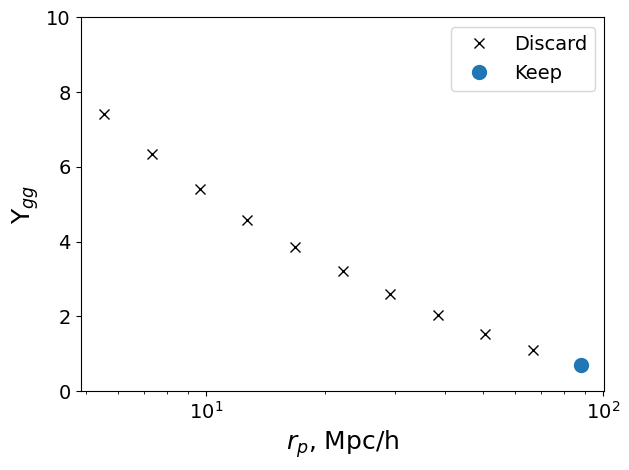

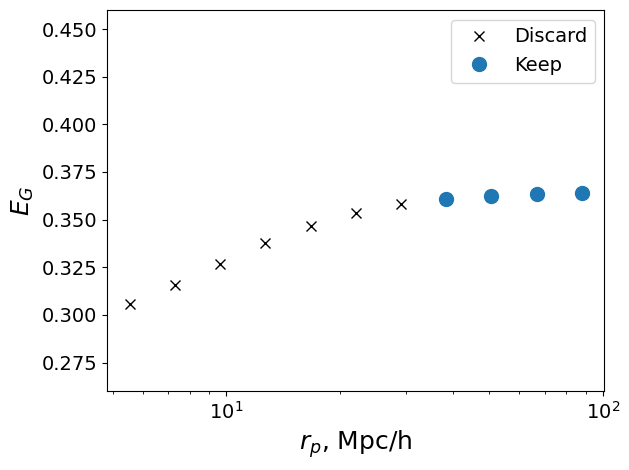

In [15]:
plt.figure()
plt.semilogx(rp_bin_c, data_nl_jp[0:len(rp_bin_c)], 'kx', markersize='7',label='Discard')
plt.semilogx(rp_keep_gm, Ups_keep_gm, 'o', markersize='10',label='Keep')
plt.ylabel('$\\Upsilon_{gm}$',fontsize=18)
plt.xlabel('$r_p$, Mpc/h', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,1.0)
plt.tight_layout()
#plt.savefig('../plots/Upsilon_gm_linearscales_nLbias_KitanisWhite2022_wHartlap_Mar2025.pdf')
plt.show()

plt.figure()
plt.semilogx(rp_bin_c, data_nl_jp[len(rp_bin_c):2*len(rp_bin_c)], 'kx', markersize='7',label='Discard')
plt.semilogx(rp_keep_gg, Ups_keep_gg, 'o', markersize='10', label='Keep')
plt.ylabel('$\\Upsilon_{gg}$',fontsize=18)
plt.xlabel('$r_p$, Mpc/h',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,10)
plt.tight_layout()
#plt.savefig('../plots/Upsilon_gg_linearscales_nLbias_KitanisWhite2022_wHartlap_Mar2025.pdf')
#plt.show()
#plt.savefig('../plots/Upsilon_gg_scales.png')

plt.figure()
plt.semilogx(rp_bin_c, data_nl_EG, 'kx', markersize='7',label='Discard')
plt.semilogx(rp_keep_Eg, Eg_keep, 'o', markersize='10',label='Keep')
plt.ylabel('$E_G$',fontsize=18)
plt.xlabel('$r_p$, Mpc/h',fontsize=18)
plt.ylim(0.26,0.46)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('../plots/EG_linearscales_nLbias_KitanisWhite2022_wHartlap_Mar2025.pdf')
#plt.show()

In [16]:
# Output the scale cuts in a readable format for later use.

cut = np.ones(len(rp_bin_c))
for i in range(0, len(rp_bin_c)):
    if i in cut_inds_Eg:
        cut[i] = 0

print('cut bins Eg=', cut_inds_Eg)
print('cut=', cut)

save_cuts = np.column_stack((rp_bin_c, cut))

np.savetxt('../txtfiles/scalecuts_nLbias_KitanidisWhite2022_Oct2025_Y10.dat', save_cuts, header='# rp bin centre,  cut this bin? 0 = Cut.')

cut bins Eg= [0, 1, 2, 3, 4, 5, 6]
cut= [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


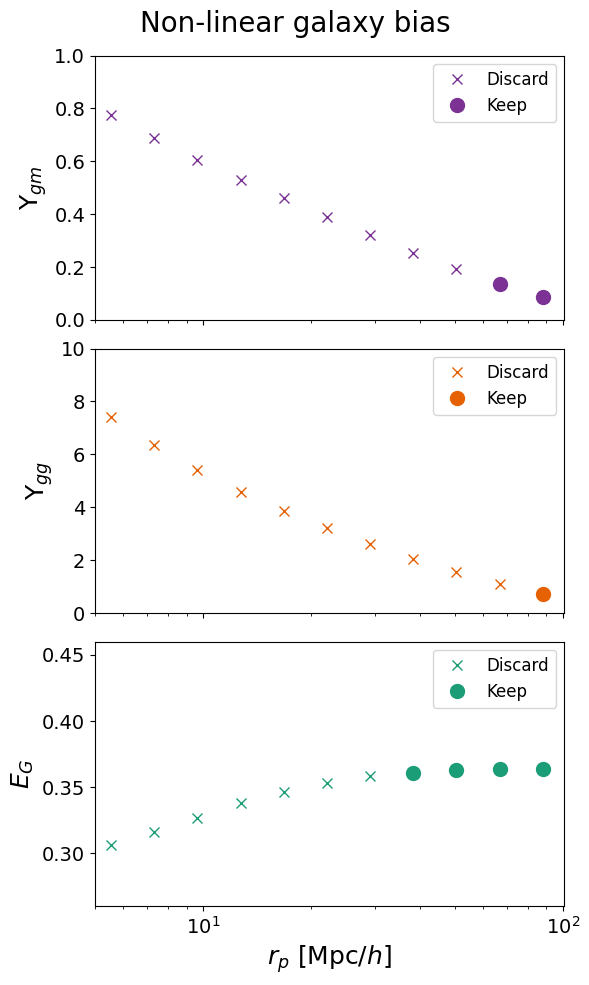

In [17]:

purple = '#7B3294'  # Upsilon_gm
orange = '#E66101'  # Upsilon_gg
teal   = '#1B9E77'  # E_G


fig, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# --- Panel 1: Upsilon_gm ---
axes[0].semilogx(rp_bin_c, data_nl_jp[0:len(rp_bin_c)], 'x', color=purple, markersize=7, label='Discard')
axes[0].semilogx(rp_keep_gm, Ups_keep_gm, 'o', color=purple, markersize=10, label='Keep')
axes[0].set_ylabel(r'$\Upsilon_{gm}$', fontsize=18)
axes[0].legend(fontsize=12)
axes[0].tick_params(labelsize=14)
axes[0].set_xlim(5, rp_bin_edges[-1])
axes[0].set_ylim(0, 1)

# --- Panel 2: Upsilon_gg ---
axes[1].semilogx(rp_bin_c, data_nl_jp[len(rp_bin_c):2*len(rp_bin_c)], 'x', color=orange, markersize=7, label='Discard')
axes[1].semilogx(rp_keep_gg, Ups_keep_gg, 'o', color=orange, markersize=10, label='Keep')
axes[1].set_ylabel(r'$\Upsilon_{gg}$', fontsize=18)
axes[1].legend(fontsize=12)
axes[1].tick_params(labelsize=14)
axes[1].set_xlim(5, rp_bin_edges[-1])
axes[1].set_ylim(0, 10)

# --- Panel 3: E_G ---
axes[2].semilogx(rp_bin_c, data_nl_EG, 'x', color=teal, markersize=7, label='Discard')
axes[2].semilogx(rp_keep_Eg, Eg_keep, 'o', color=teal, markersize=10, label='Keep')
axes[2].set_ylabel(r'$E_G$', fontsize=18)
axes[2].set_xlabel(r'$r_p$ [Mpc$/h$]', fontsize=18)
axes[2].legend(fontsize=12)
axes[2].tick_params(labelsize=14)
axes[2].set_xlim(5, rp_bin_edges[-1])
axes[2].set_ylim(0.26, 0.46)

# --- Overall Title ---
fig.suptitle('Non-linear galaxy bias', fontsize=20, y=0.98)

plt.tight_layout(h_pad=0.7)
plt.savefig('../plots/nLbias_linear_cuts_GR_rpgte5_simscov_Y10.pdf')
plt.show()